# E-learning Platform Analysis

## About

E-learning Platform has conducted an A/B test. One group of users was offered a new payment method, while the other had a previous version.

**Objectives**:
1. Evaluate experiment results and decide whether to roll out new feature or not.
2. Create a function to automate the process of metrics calculation and visualization.
3. Create SQL-queries to calculate main metrics.

**Summary**: 

A/B test results show that new payment method did not affect CR and ARPU significantly, while there is statistical significance in a set of given observations for ARPPU.
As far as there are also some data anomalies, **the next steps would be**:
- investigate whether there were some marketing campaigns or other experiments that could have influenced our results;
- postpone new payment method roll-out until further clarifications.

## Data Preprocessing

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import packages

import pandas as pd
import numpy as np
import pingouin as pg
import scipy
from scipy.stats import norm, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from tqdm.auto import tqdm
import pandahouse as ph

import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

In [3]:
DATA_PATH = "/Users/veronika/Documents/Projects/"

PATH_TO_GROUPS = DATA_PATH + "groups.csv"
PATH_TO_GROUP_ADD = DATA_PATH + "group_add.csv"
PATH_TO_ACTIVE_STUDS = DATA_PATH + "active_studs.csv"
PATH_TO_CHECKS = DATA_PATH + "checks.csv"

<IPython.core.display.Javascript object>

#### `df_groups` is a dataset dividing users into 2 groups: A - control, B - test

In [4]:
df_groups = pd.read_csv(PATH_TO_GROUPS, sep=";")

df_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


<IPython.core.display.Javascript object>

In [5]:
# Check for duplicates

df_groups.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [6]:
# Calculate group sizes

df_groups.groupby("grp", as_index=False).agg({"id": "nunique"})

,grp,id
0,A,14671
1,B,59813


<IPython.core.display.Javascript object>

#### `df_active_studs` is a dataset with users that visited platform during the experiment

In [7]:
df_active_studs = (
    pd.read_csv(PATH_TO_ACTIVE_STUDS, sep=";")
    .rename(columns={"student_id": "id"})
    .assign(active=1)
)

df_active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      8341 non-null   int64
 1   active  8341 non-null   int64
dtypes: int64(2)
memory usage: 130.5 KB


<IPython.core.display.Javascript object>

In [8]:
# Check for duplicates

df_active_studs.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [9]:
df_groups_status = df_groups.merge(df_active_studs, on="id", how="left")

not_active_with_group = df_groups_status[df_groups_status["active"].isnull()][
    "id"
].count()

print(
    f"There are {not_active_with_group} inactive users that appear either in control or test group."
)

There are 66156 inactive users that appear either in control or test group.


<IPython.core.display.Javascript object>

In [10]:
df_active_groups = df_active_studs.merge(df_groups, on="id", how="left")

active_without_group = df_active_groups[df_active_groups["grp"].isnull()][
    "active"
].sum()


print(f"There are {active_without_group} active users that do not appear in any group.")

There are 13 active users that do not appear in any group.


<IPython.core.display.Javascript object>

#### `df_checks` is a dataset with user payments during the experiment

In [11]:
df_checks = (
    pd.read_csv(PATH_TO_CHECKS, sep=";")
    .rename(columns={"student_id": "id"})
    .assign(paid=1)
)

df_checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    int64  
 1   rev     541 non-null    float64
 2   paid    541 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 12.8 KB


<IPython.core.display.Javascript object>

In [12]:
# Check for duplicates

df_checks.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [13]:
df_checks_status = df_checks.merge(df_active_studs, on="id", how="left")

not_active_with_checks = df_checks_status[df_checks_status["active"].isnull()][
    "id"
].count()

print(f"There are {not_active_with_checks} inactive users who have paid.")

There are 149 inactive users who have paid.


<IPython.core.display.Javascript object>

In [14]:
df_checks_groups = df_checks.merge(df_groups, on="id", how="left")

checks_without_groups = df_checks_groups[df_checks_groups["grp"].isnull()]["id"].count()

print(
    f"There is {checks_without_groups} user, who have paid, but do not appear in any group."
)

There is 1 user, who have paid, but do not appear in any group.


<IPython.core.display.Javascript object>

####  `df_groups`&`df_active_studs`&`df_checks` 

In [15]:
# Merge all datasets

df = (
    df_groups.merge(df_active_studs, on="id", how="left")
    .merge(df_checks, on="id", how="left")
    .fillna(0)
)
df.head(5)

,id,grp,active,rev,paid
0,1489,B,0.0,0.0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [16]:
# Delete 149 inactive users who have paid

df.drop(df.index[(df["paid"] == 1) & (df["active"] == 0)], inplace=True)

<IPython.core.display.Javascript object>

#### `df_group_add` is a dataset with groups of users, that was received 2 days after the experiment has started

In [17]:
df_group_add = pd.read_csv(PATH_TO_GROUP_ADD, sep=",")

df_group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


<IPython.core.display.Javascript object>

In [18]:
# Check for duplicates

df_group_add.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [19]:
# Calculate group sizes

df_group_add.groupby("grp", as_index=False).agg({"id": "nunique"})

,grp,id
0,A,22
1,B,70


<IPython.core.display.Javascript object>

In [20]:
# Merge with other datasets

df_group_add.merge(df_active_studs, on="id", how="left").merge(
    df_checks, on="id", how="left"
).fillna(0).groupby("grp", as_index=False).agg({"active": "sum", "paid": "sum"})

,grp,active,paid
0,A,3.0,0.0
1,B,10.0,1.0


<IPython.core.display.Javascript object>

**Main outcomes:**
- there are 4 times more users in test group than in control
- there are 66156 inactive users, who appear either in control or test group
- there are 13 active users, who do not appear in any group
- there is 1 user, who have paid, but do not appear in any group
- there are 149 inactive users, who have paid (could be an auto payment) - as these users were not able to test new payment method, they won't participate in further analysis

## Analysis

### 1. Evaluating experiment results

To have a deeper understanding of experiment results I will calculate the following **metrics**:
- `ARPU` (Average Revenue Per User) = Total Revenue / Total number of Users
- `ARPPU` (Average Revenue Per Paying User) = Total Revenue / Total number of Paying Users
- `CR` (Conversion Rate) = Total number of Paying Users / Total number of Users

#### 1.1 Calculating Metrics (ARPU, ARPPU, CR)

In [21]:
df_arpu = (
    df.groupby("grp", as_index=False)
    .agg({"rev": "sum", "id": "count"})
    .rename(columns={"id": "users"})
)

df_arpu["ARPU"] = round(df_arpu["rev"] / df_arpu["users"], 2)

df_arpu

,grp,rev,users,ARPU
0,A,72820.0000,14642,4.97
1,B,393074.0035,59693,6.58


<IPython.core.display.Javascript object>

In [22]:
df_arppu = (
    df.query("rev > 0")
    .groupby("grp", as_index=False)
    .agg({"rev": "sum", "paid": "sum"})
    .rename(columns={"paid": "paid_users"})
)

df_arppu["ARPPU"] = round(df_arppu["rev"] / df_arppu["paid_users"], 2)

df_arppu

,grp,rev,paid_users,ARPPU
0,A,72820.0000,78.0,933.59
1,B,393074.0035,313.0,1255.83


<IPython.core.display.Javascript object>

In [23]:
df_cr = (
    df.groupby("grp", as_index=False)
    .agg({"id": "count", "paid": "sum"})
    .rename(columns={"id": "all_users", "paid": "paid_users"})
)

df_cr["CR"] = round(df_cr["paid_users"] / df_cr["all_users"] * 100, 2)

df_cr

,grp,all_users,paid_users,CR
0,A,14642,78.0,0.53
1,B,59693,313.0,0.52


<IPython.core.display.Javascript object>

In [24]:
df_metrics = pd.concat(
    [df_arpu[["grp", "ARPU"]], df_arppu["ARPPU"], df_cr["CR"]], axis=1
)
df_metrics

,grp,ARPU,ARPPU,CR
0,A,4.97,933.59,0.53
1,B,6.58,1255.83,0.52


<IPython.core.display.Javascript object>

Analysing the table above it is evident, that ARPU and ARPPU have increased, while CR on the contrary have decreased. 

As far as datasets do not have information about number of transactions made by user, then in this case ARPPU is the same as an Average Check. 

Knowing that ARPU = ARPPU * CR I can assume, that either the average price of learning has increased or some promotional activities took place, which led to the decrease of CR and increase of ARPPU and ARPU accordingly.

#### 1.2 A/B test

Now it's time to check whether the differences found are statistically significant.

First, let's have a look at checks distribution.

<AxesSubplot:xlabel='rev', ylabel='Count'>

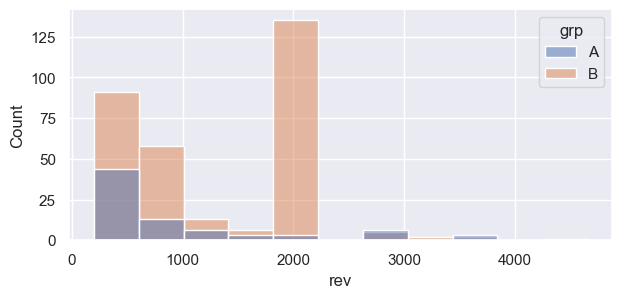

<IPython.core.display.Javascript object>

In [25]:
sns.set_theme()

fig, axs = plt.subplots(figsize=(7, 3))

sns.histplot(data=df[df["rev"] > 0], x="rev", hue="grp")

From the plot above it's obvious, that distribution is not normal. Moreover, there is a huge increase in number of checks around 2000 RUB, the majority of which is in test group.

To test **ARPU** and **ARPPU** I will first check whether:
- metrics are homoscedastic and 
- statistic is normally distributed (using **bootstrap**). 

In case both criteria are met I'll use **t-test**.

**$H_0$** means that new payment method did not influence ARPU and ARPPU significantly different than the old one.

In [26]:
# Set confidence level

conf = 0.95
alpha = 1 - conf

<IPython.core.display.Javascript object>

In [27]:
# Create bootstrap function


def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=conf,
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(boot_len, replace=True).values

        samples_2 = data_column_2.sample(boot_len, replace=True).values

        boot_data.append(statistic(samples_1 - samples_2))

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    # Visualization

    plt.hist(pd_boot_data[0], bins=50)

    plt.style.use("ggplot")
    plt.vlines(ci, ymin=0, ymax=50, linestyle="--")
    plt.xlabel("boot_data")
    plt.ylabel("frequency")
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data, "ci": ci, "p_value": p_value}

<IPython.core.display.Javascript object>

#### ARPU A/B test

In [28]:
arpu_experiment = df
arpu_control = df[df["grp"] == "A"]["rev"]
arpu_test = df[df["grp"] == "B"]["rev"]

<IPython.core.display.Javascript object>

In [29]:
pg.homoscedasticity(data=arpu_experiment, dv="rev", group="grp", method="levene")

,W,pval,equal_var
levene,2.770914,0.095996,True


<IPython.core.display.Javascript object>

  0%|          | 0/1000 [00:00<?, ?it/s]

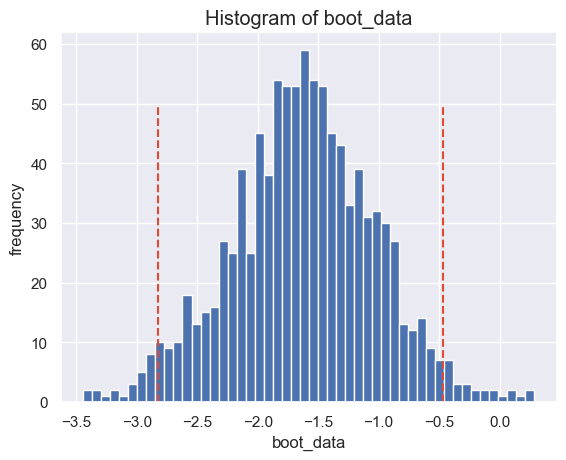

<IPython.core.display.Javascript object>

In [30]:
booted_data_mean_arpu = get_bootstrap(arpu_control, arpu_test)

In [31]:
arpu_p_value = booted_data_mean_arpu["p_value"]

arpu_lower_ci = booted_data_mean_arpu["ci"].iloc[0, 0]
arpu_upper_ci = booted_data_mean_arpu["ci"].iloc[1, 0]

print(f"p-value: {arpu_p_value:.3f}")
print(f"ci 95%: [{arpu_lower_ci:.3f}, {arpu_upper_ci:.3f}]")

if arpu_p_value <= alpha:
    print("H0 is rejected")
else:
    print("H0 can not be rejected")

p-value: 0.006
ci 95%: [-2.826, -0.465]
H0 is rejected


<IPython.core.display.Javascript object>

In [32]:
scipy.stats.ttest_ind(arpu_control, arpu_test)

if scipy.stats.ttest_ind(arpu_control, arpu_test)[1] < alpha:
    print("H0 is rejected")
else:
    print("H0 can not be rejected")

H0 can not be rejected


<IPython.core.display.Javascript object>

#### ARPPU A/B test

In [33]:
arppu_experiment = df[df["paid"] == 1]
arppu_control = df[(df["grp"] == "A") & (df["paid"] == 1)]["rev"]
arppu_test = df[(df["grp"] == "B") & (df["paid"] == 1)]["rev"]

<IPython.core.display.Javascript object>

In [34]:
pg.homoscedasticity(data=arppu_experiment, dv="rev", group="grp", method="levene")

,W,pval,equal_var
levene,3.055864,0.081235,True


<IPython.core.display.Javascript object>

  0%|          | 0/1000 [00:00<?, ?it/s]

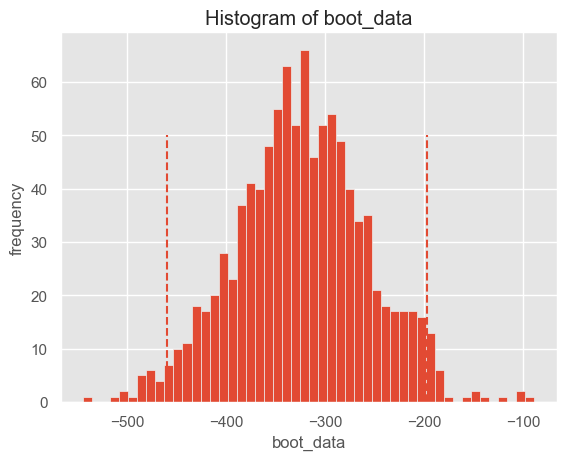

<IPython.core.display.Javascript object>

In [35]:
booted_data_mean_arppu = get_bootstrap(arppu_control, arppu_test)

In [36]:
arppu_p_value = booted_data_mean_arppu["p_value"]

arppu_lower_ci = booted_data_mean_arppu["ci"].iloc[0, 0]
arppu_upper_ci = booted_data_mean_arppu["ci"].iloc[1, 0]

print(f"p-value: {arppu_p_value:.3f}")
print(f"ci 95%: [{arppu_lower_ci:.3f}, {arppu_upper_ci:.3f}]")

if arppu_p_value <= alpha:
    print("H0 is rejected")
else:
    print("H0 can not be rejected")

p-value: 0.000
ci 95%: [-459.936, -197.187]
H0 is rejected


<IPython.core.display.Javascript object>

In [37]:
scipy.stats.ttest_ind(arppu_control, arppu_test)

if scipy.stats.ttest_ind(arppu_control, arppu_test)[1] < alpha:
    print("H0 is rejected")
else:
    print("H0 can not be rejected")

H0 is rejected


<IPython.core.display.Javascript object>

#### CR A/B test

As the **conversion** is a binomial value, it is better to use **z-test** or **chi-squared test**.

**$H_0$** means that new payment method did not influence CR significantly different than the old one.

In [38]:
cr_crosstab = pd.crosstab(df["grp"], df["paid"])

cr_stat, cr_p, cr_dof, cr_expected = chi2_contingency(cr_crosstab)

if cr_p <= alpha:
    print(f"p-value: {cr_p:.3f}")
    print("H0 is rejected")
else:
    print(f"p-value: {cr_p:.3f}")
    print("H0 can not be rejected")

p-value: 0.951
H0 can not be rejected


<IPython.core.display.Javascript object>

In [39]:
cr_control_results = df[df["grp"] == "A"]["paid"]
cr_test_results = df[df["grp"] == "B"]["paid"]

cr_num_control = cr_control_results.count()
cr_num_test = cr_test_results.count()
cr_successes = [cr_control_results.sum(), cr_test_results.sum()]
cr_nobs = [cr_num_control, cr_num_test]

cr_z_stat, cr_pval = proportions_ztest(cr_successes, nobs=cr_nobs)
(cr_lower_control, cr_lower_test), (
    cr_upper_control,
    cr_upper_test,
) = proportion_confint(cr_successes, nobs=cr_nobs, alpha=alpha)

print(f"z statistic: {cr_z_stat:.2f}")
print(f"p-value: {cr_pval:.3f}")
print(f"ci 95% for control group: [{cr_lower_control:.3f}, {cr_upper_control:.3f}]")
print(f"ci 95% for treatment group: [{cr_lower_test:.3f}, {cr_upper_test:.3f}]")

if cr_pval <= alpha:
    print("H0 is rejected")
else:
    print("H0 can not be rejected")

z statistic: 0.13
p-value: 0.900
ci 95% for control group: [0.004, 0.007]
ci 95% for treatment group: [0.005, 0.006]
H0 can not be rejected


<IPython.core.display.Javascript object>

**A/B test results**:
- for CR and ARPU we can not reject null hypothesis, which means that new payment method did not affect CR and ARPU significantly;
- while for ARPPU we reject null hypothesis, which means that there is statistical significance in a set of given observations.

As far as there are data anomalies such as huge increase in number of checks around 2000 RUB in test group and 
significant difference in number of users in control and test groups, **the next steps would be**:
1. investigate whether there were some marketing campaigns or other experiments that could have influenced our results; 
2. postpone new payment method roll-out until further clarifications.

### 2. Creating a function to automate the process

In [40]:
# Create a function to get data


def get_data(PATH_TO_GROUPS, PATH_TO_GROUP_ADD, PATH_TO_ACTIVE_STUDS, PATH_TO_CHECKS):

    df_groups = pd.read_csv(PATH_TO_GROUPS, sep=";")
    df_group_add = pd.read_csv(PATH_TO_GROUP_ADD, sep=",")
    df_active_studs = (
        pd.read_csv(PATH_TO_ACTIVE_STUDS, sep=";")
        .rename(columns={"student_id": "id"})
        .assign(active=1)
    )
    df_checks = (
        pd.read_csv(PATH_TO_CHECKS, sep=";")
        .rename(columns={"student_id": "id"})
        .assign(paid=1)
    )

    df_experiment_groups = pd.concat([df_groups, df_group_add], ignore_index=True)

    df = df_experiment_groups.merge(df_active_studs, on="id", how="left").fillna(0)
    df = df.merge(df_checks, on="id", how="left").fillna(0)

    return df

<IPython.core.display.Javascript object>

In [41]:
# Create a function to calculate metrics


def calculate_mertics(df):

    df_arpu = (
        df.groupby("grp", as_index=False)
        .agg({"rev": "sum", "id": "count"})
        .rename(columns={"id": "users"})
    )
    df_arpu["ARPU"] = round(df_arpu["rev"] / df_arpu["users"], 2)

    df_arppu = (
        df.query("rev > 0")
        .groupby("grp", as_index=False)
        .agg({"rev": "sum", "paid": "sum"})
        .rename(columns={"paid": "paid_users"})
    )
    df_arppu["ARPPU"] = round(df_arppu["rev"] / df_arppu["paid_users"], 2)

    df_cr = (
        df.groupby("grp", as_index=False)
        .agg({"id": "count", "paid": "sum"})
        .rename(columns={"id": "all_users", "paid": "paid_users"})
    )
    df_cr["CR"] = round(df_cr["paid_users"] / df_cr["all_users"] * 100, 2)

    df_metrics = pd.concat(
        [df_arpu[["grp", "ARPU"]], df_arppu["ARPPU"], df_cr["CR"]], axis=1
    )

    return df_metrics

<IPython.core.display.Javascript object>

In [42]:
# Create a function to update metrics automatically


def update_metrics(
    PATH_TO_GROUPS, PATH_TO_GROUP_ADD, PATH_TO_ACTIVE_STUDS, PATH_TO_CHECKS
):

    df = get_data(
        PATH_TO_GROUPS, PATH_TO_GROUP_ADD, PATH_TO_ACTIVE_STUDS, PATH_TO_CHECKS
    )
    df_metrics = calculate_mertics(df)

    return df_metrics

<IPython.core.display.Javascript object>

In [43]:
update_metrics(PATH_TO_GROUPS, PATH_TO_GROUP_ADD, PATH_TO_ACTIVE_STUDS, PATH_TO_CHECKS)

,grp,ARPU,ARPPU,CR
0,A,6.27,860.71,0.73
1,B,8.04,1108.82,0.72


<IPython.core.display.Javascript object>

In [44]:
# Create a function to visualize metrics


def visualize_data(df_metrics):

    sns.set_theme()

    fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

    viz_arpu = sns.barplot(data=df_metrics, x="grp", y="ARPU", ax=axs[0])
    viz_arpu.set_xlabel("Experiment Group")
    viz_arpu.set_ylabel("USD")
    viz_arpu.set_title("ARPU", fontsize=20)

    viz_arpau = sns.barplot(data=df_metrics, x="grp", y="ARPPU", ax=axs[1])
    viz_arpau.set_xlabel("Experiment Group")
    viz_arpau.set_ylabel("USD")
    viz_arpau.set_title("ARPPU", fontsize=20)

    viz_arppu = sns.barplot(data=df_metrics, x="grp", y="CR", ax=axs[2])
    viz_arppu.set_xlabel("Experiment Group")
    viz_arppu.set_ylabel("Percentage")
    viz_arppu.set_title("CR", fontsize=20)

    plt.show()

<IPython.core.display.Javascript object>

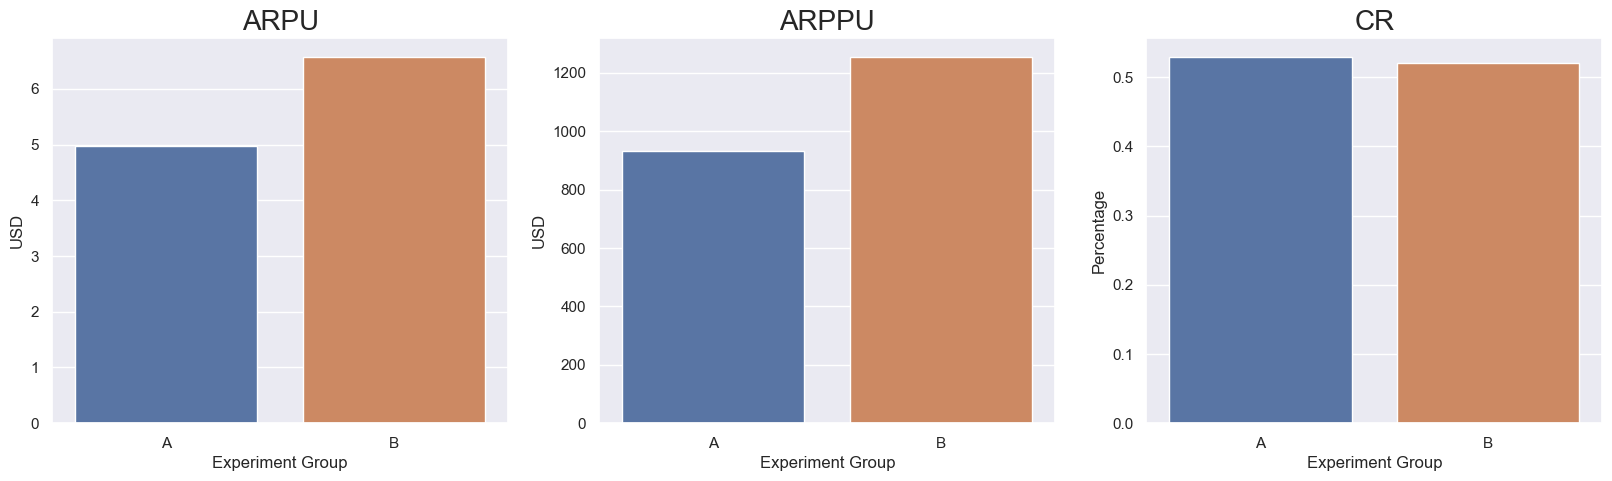

<IPython.core.display.Javascript object>

In [45]:
visualize_data(df_metrics)

### 3. Creating SQL-queries to calculate main metrics

#### 3.1 The most diligent students

The objective is to calculate the number of diligent students (those who successfully completed more than 20 tasks). 

In [46]:
connection_default = {
    "host": "http://clickhouse.beslan.pro:8080",
    "database": "default",
    "user": "student",
    "password": "dpo_python_2020",
}

<IPython.core.display.Javascript object>

In [47]:
q_1 = """
    SELECT
        timest_month,
        COUNT(st_id) AS diligent_students
    FROM(
        SELECT 
            st_id,
            SUM(correct) AS success_tasks,
            toStartOfMonth(timest) AS timest_month
        FROM default.peas
        GROUP BY timest_month, st_id
        HAVING success_tasks >= 20
        )
    GROUP BY timest_month
    """

<IPython.core.display.Javascript object>

In [48]:
q_diligent_students = ph.read_clickhouse(query=q_1, connection=connection_default)
q_diligent_students

,timest_month,diligent_students
0,2021-10-01,136


<IPython.core.display.Javascript object>

#### 3.2 Funnel optimization

E-learning Platform offers the trial version, using which students can solve only 30 tasks a day for free. To have an unlimited number of tasks in a particular discipline, the full access must be purchased.

The e-learning team desided to run an experiment to test the new payment screen. Having experiment results, the objective now is to calculate the following metrics for control and test groups:
- ARPU
- ARPAU
- CR
- CR of active students
- CR of active students in Math

*Student is considered as an active, if he successfully completes more than 10 tasks in any discipline. \
Student is considered as an active in Math, if he successfully completes 2 and more tasks in Math.*

In [49]:
q_2 = """
    SELECT
        test_grp,
        ROUND(SUM(sum_purchased)/COUNT(groups.st_id),2) AS ARPU,
        ROUND(sumIf(sum_purchased, is_active = '1')/SUM(is_active),2) AS ARPAU,
        ROUND(SUM(has_purchased)/COUNT(groups.st_id)*100,2) AS CR,
        ROUND(sumIf(has_purchased, is_active = '1')/SUM(is_active)*100,2) AS CR_active,
        ROUND(sumIf(has_math_purchased, is_math_active = '1')/SUM(is_math_active)*100,2) AS CR_math_active
    FROM (
        SELECT *
        FROM default.studs) AS groups
    LEFT JOIN(
        SELECT
            st_id,
            has_purchased,
            sum_purchased,
            has_math_purchased,
            sum_math_purchased
        FROM (
            SELECT 
                st_id,
                COUNT(DISTINCT(st_id)) AS has_purchased,
                SUM(money) AS sum_purchased
            FROM default.final_project_check
            GROUP BY st_id) AS a
        LEFT JOIN (
            SELECT 
                st_id,
                COUNT(DISTINCT(st_id)) AS has_math_purchased,
                SUM(money) AS sum_math_purchased
            FROM default.final_project_check
            WHERE subject = 'Math'
            GROUP BY st_id) AS b
        ON a.st_id = b.st_id) AS purchases
    ON groups.st_id = purchases.st_id
    LEFT JOIN (
        SELECT
            IF(c.st_id = '', d.st_id, c.st_id) AS st_id_active,
            is_active,
            is_math_active
        FROM(    
            SELECT
                st_id,
                COUNT(st_id) AS is_active
            FROM(
                SELECT 
                    st_id,
                    SUM(correct) AS correct_tasks
                FROM default.peas
                GROUP BY st_id
                HAVING correct_tasks > 10)
            GROUP BY st_id) AS c
        FULL JOIN(
            SELECT
                st_id,
                COUNT(st_id) AS is_math_active
            FROM(
                SELECT 
                    st_id,
                    SUM(correct) AS correct_tasks
                FROM default.peas
                WHERE subject = 'Math'
                GROUP BY st_id
                HAVING correct_tasks >= 2)
            GROUP BY st_id) AS d
        ON c.st_id = d.st_id) AS active
    ON groups.st_id = active.st_id_active
    GROUP BY test_grp
    """

<IPython.core.display.Javascript object>

In [50]:
q_metrics = ph.read_clickhouse(query=q_2, connection=connection_default)
q_metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math_active
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


<IPython.core.display.Javascript object>